In [4]:
import numpy as np
import os
import pandas as pd
import torch
from PIL import Image
import torchvision
import omegaconf
from omegaconf import OmegaConf
from collections import Counter

print(os.getcwd())
if os.getcwd().split(os.sep)[-1] == 'notebooks':
    os.chdir('..') # set ccwd as the parent directory to make imports easier

# from datasets.domain_net import DomainNet
from datasets.base import VisImageFolder
from datasets.get_dataset import get_dataset

/home/lisabdunlap/second_split_forgetting


In [5]:
cfg = OmegaConf.load('configs/base.yaml')
get_dataset('DomainNetV1', cfg, split='train')

Get dataset DomainNetV1


Dataset DomainNet
    Number of datapoints: 5816
    Root location: /shared/lisabdunlap/data/domainnet_noisy

In [6]:
cfg = OmegaConf.load('configs/base.yaml')
get_dataset('DomainNetV1', cfg, split='val')

Get dataset DomainNetV1


Dataset DomainNet
    Number of datapoints: 992
    Root location: /shared/lisabdunlap/data/domainnet

In [134]:
data = VisImageFolder('/shared/lisabdunlap/data/domainnet/clipart', transform=None)

In [242]:
class DomainNet(VisImageFolder):

    def __init__(self, root, cfg, domains, split='train', transform=None):
        super().__init__(root, transform=transform)
        if type(domains) == str: # for single domain
            domains = [domains]
        self.root = root
        self.cfg = cfg
        self.split = split
        self.transform = transform
        self.domains = sorted(domains)
        if cfg.dataset.classes.file:
            with open(cfg.dataset.classes.file) as f:
                self.classes = [c.replace(' ', '_') for c in f.read().splitlines()]
        else:
            self.classes = cfg.dataset.classes.class_list
        self.samples, self.labels, self.img_paths, self.groups = [], [], [], []
        file_split = 'test' if self.split == 'val' else self.split
        for i, domain in enumerate(self.domains):
            with open(f'{root}/{domain}_{file_split}.txt') as f:
                samples = [(os.path.join(root, i.split(' ')[0]), int(i.split(' ')[1])) for i in f.read().splitlines()]
            class_names = [s[0].split('/')[6] for s in samples]
            samples = [(s[0], self.classes.index(class_names[i])) for i, s in enumerate(samples) if class_names[i] in self.classes]
            if domain != 'real' and split == 'train':
                samples = list(np.array(samples)[np.random.choice(list(range(len(samples))), 1000, replace=False)])
            elif split  != 'train':
                balanced_samples = []
                for j in range(len(self.classes)):
                    subsample = [s for s in samples if s[1] == j]
                    balanced_samples += list(np.array(subsample)[np.random.choice(list(range(len(subsample))), 31, replace=False)])
                samples = balanced_samples

            # sort out classes
            self.samples += samples
            self.groups += [i for _ in range(len(samples))]
        self.samples = [(s[0], self.classes.index(s[0].split('/')[6])) for s in self.samples]
        # if split == 'val':
        #     self.samples = self.samples[::2]
        #     self.groups = self.groups[::2]
        # if split == 'test':
        #     self.samples = self.samples[1::2]
        #     self.groups = self.groups[1::2]
        self.labels = [s[1] for s in self.samples]
        self.img_paths = [s[0] for s in self.samples]
        # self.class_weights = get_counts(self.labels)
        assert len(self.samples) == len(self.labels) == len(self.img_paths) == len(self.groups), "samples, labels, img_paths, and groups should be the same length"

    def __getitem__(self, idx):
        img, label, group, idx = super().__getitem__(idx)
        return img, label, self.groups[idx], idx

real umbrella


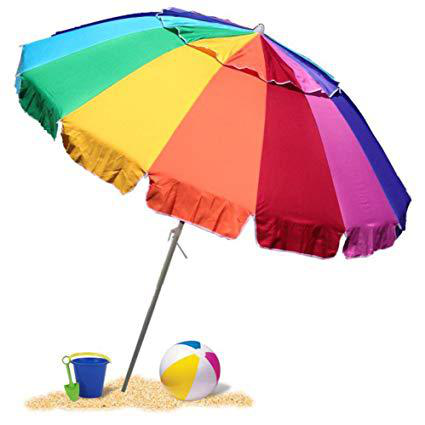

In [236]:
cfg = OmegaConf.load('configs/domainnet/dataset.yaml')
cfg.dataset.source = 'clipart'


train_set = DomainNet('/shared/lisabdunlap/data/domainnet_noisy', cfg, domains=['real', 'painting', 'clipart', 'infograph'], split='train', transform=None)
idx = np.random.choice(list(range(len(train_set))))
img, label, group, idx = train_set[idx]
print(train_set.domains[group], train_set.classes[label])
img

In [237]:
len(train_set.classes), len(train_set), Counter(train_set.groups)

(8, 5816, Counter({0: 1000, 1: 1000, 2: 1000, 3: 2816}))

In [238]:
df = pd.DataFrame({"groups": train_set.groups, "labels": train_set.labels})
df = df.groupby(['labels'], as_index=False)[['groups', 'labels']].count()
# min_label, min_count = df['labels'].argmin(), df['labels'].min()
df

,groups,labels
0,772,772
1,866,866
2,758,758
3,644,644
4,831,831
5,629,629
6,671,671
7,645,645


In [243]:
val_set = DomainNet('/shared/lisabdunlap/data/domainnet', cfg, domains=['real', 'painting', 'clipart', 'infograph'], split='val', transform=None)
Counter(val_set.groups)

Counter({0: 248, 1: 248, 2: 248, 3: 248})

In [244]:
classes = Counter(val_set.labels)
min(list(classes.values()))

df = pd.DataFrame({"groups": val_set.groups, "labels": val_set.labels, "img_paths": val_set.img_paths})
df = df.groupby(['groups', 'labels'], as_index=False)['img_paths'].count()
min_label, min_count = df['img_paths'].argmin(), df['img_paths'].min()
df

,groups,labels,img_paths
0,0,0,31
1,0,1,31
2,0,2,31
3,0,3,31
4,0,4,31
5,0,5,31
6,0,6,31
7,0,7,31
8,1,0,31
9,1,1,31


In [245]:
overlap_classes = []
for k, v in Counter(min_df.labels).items():
    if v == 4:
        overlap_classes.append(k)
overlap_classes, [val_set.classes[c] for c in overlap_classes]

([0, 1, 2, 3, 4, 5, 6, 7],
 ['streetlight',
  'table',
  'vase',
  'suitcase',
  'teapot',
  'wine_glass',
  'pillow',
  'umbrella'])